In [1]:
import mplfinance as mpf
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
API_keys = open('API_KEYS.txt',"r").read().split()

In [3]:
# Runs through stock data and calls strategies and graphs
def algorithims(ticker,cash,show_transactions,show_graphs):
    # Loads in dataframe and renames columns
    API_key = API_keys[random.randint(0,8)]
    time = TimeSeries(key = API_key,output_format='pandas')
    data = time.get_intraday(symbol=ticker,interval='1min',outputsize='full')[0].rename(columns={"1. open":"Open","2. high":"High","3. low":"Low","4. close":"Close","5. volume":"Volume"})
    data = data.sort_index()
    # Splits dataframe into a list of dataframes of each day
    days = [group[1] for group in data.groupby(data.index.dayofyear)]
    num_days = len(days) 
    # Initialize returns for strategies
    strategy1_returns = np.empty(0)
    strategy2_returns = np.empty(0)
    strategy3_returns = np.empty(0)
    strategy4_returns = np.empty(0)
    market_returns = np.empty(0)
    # Loops through dataframes and performs strategies and graphs
    for df in days:
        # Limits data to only during trading hours
        df = df.loc[(df.index >= f'{df.index.date[0]} 9:30:00')]
        df = df.loc[(df.index <= f'{df.index.date[0]} 16:00:00')]   
        # Aggregates one minutes 
        df = df.resample('5T').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})  
        # Add calculated columns for desired indicators 
        df['VWAP'] = (((df['High']+df['Low']+df['Close'])*df['Volume']/3).cumsum())/df['Volume'].cumsum()
        df['percent'] = ((df['Close'])-df['VWAP'])/df['VWAP']
        df['TWAP'] = ((df['Open'] + df['High'] + df['Low'] + df['Close'])/4).expanding().mean()
        df["EMA10"] = df['Close'].ewm(span=10, adjust=False).mean()
        df["EMA20"] = df['Close'].ewm(span=20, adjust=False).mean()
        

        df = df.dropna()
        # Plot indicators and price
        if show_graphs:
            title = f'{df.index[0].month_name()} {df.index[0].day}, {data.index[0].year} {ticker}'
            vwap = mpf.make_addplot(df['VWAP'])
            twap = mpf.make_addplot(df['TWAP'])
            ema10 = mpf.make_addplot(df['EMA10'])
            ema20 = mpf.make_addplot(df['EMA20'])
            fig, axes = mpf.plot(df,addplot=[vwap,twap,ema10,ema20],type='candle',style='yahoo',volume=True,title=title,returnfig=True)
            axes[0].legend( ['VWAP','TWAP','EMA10','EMA20'] )
            plt.show()
              
        # Run strategies and add up returns using numpy arrays
        strategy1_returns = np.append(strategy1_returns,strategy1(df,ticker,cash/num_days,show_transactions))
        strategy2_returns = np.append(strategy2_returns,strategy2(df,ticker,cash/num_days,show_transactions))
        strategy3_returns = np.append(strategy3_returns,strategy3(df,ticker,cash/num_days,show_transactions))
        strategy4_returns = np.append(strategy4_returns,strategy4(df,ticker,cash/num_days,show_transactions))
        market_returns = np.append(market_returns,market(df,ticker,cash/num_days))
    # Plots the price of the stock over the period
    if show_graphs:
        title = f'{data.index[0].month_name()} {data.index[0].day}, {data.index[0].year}-{data.index[-1].month_name()} {data.index[-1].day}, {data.index[-1].year} {ticker}'
        mpf.plot(data,type='line',style='yahoo',title=title)
    returns = np.array([strategy1_returns,strategy2_returns,strategy3_returns,strategy4_returns,market_returns])
    return returns 

In [4]:
# VWAP Cross:
# Long when price crosses above VWAP and short when VWAP goes below
def strategy1(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP Cross strategy with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            long = row['VWAP'] < row['Close'] 
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Long position 
        if ((row['VWAP'] < row['Close']) and (row['VWAP'] < row['Close']) and short):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
        # Short position
        if ((row['VWAP'] > row['Close']) and (row['VWAP'] > row['Close']) and long):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [5]:
# VWAP Mean Reversion: 
# Long at troughs and short at peaks with assumption that price will return to VWAP
def strategy2(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP Mean reversion with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    percent_from_mean = 0.01
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            long = row['VWAP'] > row['Close'] 
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Long position 
        if ((row['percent'] < -(percent_from_mean)) and short):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
        # Short position
        if ((row['percent'] > percent_from_mean) and long):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [6]:
# EMA
# Uses the cross of a fast (10Day) and slow (20Day) moving as a signal to buy or sell
def strategy3(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting EMA Cross strategy with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    transactions = 0
    for index,row in df.iterrows():
        # if (not i): 
            # sets initial position based on inital VWAP and price
            # long = row['VWAP'] < row['Close'] 
            # short = not long
            # transactions += 1
            # i += 1
            # if long:
            #     shares = cash/row['Close']
            #     cash = 0
            #     if show_transactions:
            #         print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            # if short:
            #     shorts = cash/row['Close']
            #     cash = cash0*2
            #     if show_transactions:
            #         print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
        # Buy position 
        if ( ( row['EMA10'] > row['EMA20'] ) and cash ):
            shares = cash/row['Close']
            cash = 0
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 1
        
        # Sell position
        if ( ( row['EMA10'] < row['EMA20'] ) and not cash):
            cash = shares*row['Close']
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share") 
            shares = 0
            transactions += 1
        price = row['Close']
    # Exit position and calculate returns
    if show_transactions:
        print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
    cash += shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [7]:
# TWAP + VWAP strategy
# Long when price is greater than VWAP and TWAP and VWAP > TWAP
# Short when price is less than VWAP and TWAP and VWAP < TWAP
def strategy4(df,ticker,cash,show_transactions):
    # Prints which day this is
    date = df.index.date[0]
    if show_transactions:
        print(f'{date}: Starting VWAP Cross strategy with ${cash} USD')
    # Initialize variables
    i = 0
    cash0 = cash
    shares = 0
    shorts = 0
    transactions = 0
    for index,row in df.iterrows():
        if (not i): 
            # sets initial position based on inital VWAP and price
            long = row['VWAP'] < row['Close'] 
            short = not long
            transactions += 1
            i += 1
            if long:
                shares = cash/row['Close']
                cash = 0
                if show_transactions:
                    print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            if short:
                shorts = cash/row['Close']
                cash = cash0*2
                if show_transactions:
                    print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
                    
        # Long position 
        if ((row['VWAP'] < row['Close']) and (row['VWAP'] < row['Close']) and short):
            if show_transactions:
                print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            cash -= shorts*row['Close']
            shares = cash/row['Close']
            shorts = 0
            long = True   
            short = not long
            if show_transactions:
                print(f"{index.time()}: Buy {shares:.3f} {ticker} shares at {row['Close']} per share")
            transactions += 2
            
        # Short position
        if ((row['VWAP'] > row['Close']) and (row['VWAP'] > row['Close']) and long):
            if show_transactions:
                print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
            cash = shares*row['Close']*2
            shorts = shares
            shares = 0       
            short = True
            long = not short
            if show_transactions:
                print(f"{index.time()}: Open {shorts:.3f} {ticker} short contracts at {row['Close']} per contract")
            transactions += 2
        price = row['Close']
        
    # Exit position and calculate returns
    if short: 
        if show_transactions:
            print(f"{index.time()}: Close {shorts:.3f} {ticker} short contracts at {price} per contract")
        cash -= shorts*price
    if long:
        if show_transactions:
            print(f"{index.time()}: Sell {shares:.3f} {ticker} shares at {row['Close']} per share")
        cash = shares*price
    transactions += 1
    returns = (cash - cash0)/cash0
    if show_transactions:
        print(f'Cash: {cash}')
        print(f'Return: {returns*100:.2f}%')
        print(f'Transactions: {transactions}')
        print('-'*70)
    return cash

In [8]:
# Market Performance:
# Returns if you bought at open and sold at close
def market(df,ticker,cash):
    open_price = df['Open'].loc[f'{df.index.date[0]} 9:30:00']
    shares = cash/open_price
    close_price = df['Close'].loc[f'{df.index.date[0]} 16:00:00']
    return shares*close_price

In [9]:
# Prints returns for each strategy for one stock at a time
def print_stock_returns(ticker,returns,cash_per_stock):
    print(f'{ticker} Returns')
    for i in range(0,returns.shape[0]-1):
        print(f'Strategy {i+1}: {(np.sum(returns[i]) - cash_per_stock)*100/cash_per_stock:.3f}%')
    print(f'Market    : {(np.sum(returns[-1]) - cash_per_stock)*100/cash_per_stock:.3f}%')
    print('-'*50)

In [10]:
# Prints returns for each strategy overall
def print_summary_returns(all_returns,cash):
    strat1 = 0
    strat2 = 0
    strat3 = 0
    strat4 = 0
    market = 0
    for i in range(0,all_returns.shape[0]):
        if i % 5 == 0:
            strat1 += all_returns[i].sum()
        if i % 5 == 1:
            strat2 += all_returns[i].sum()
        if i % 5 == 2:
            strat3 += all_returns[i].sum()
        if i % 5 == 3:
            strat4 += all_returns[i].sum()
        if i % 5 == 4:
            market += all_returns[i].sum()
    print('Portfolio Returns')
    print(f'Strategy 1: {(strat1-cash)*100/cash:.3f}%')
    print(f'Strategy 2: {(strat2-cash)*100/cash:.3f}%')
    print(f'Strategy 3: {(strat3-cash)*100/cash:.3f}%')
    print(f'Strategy 4: {(strat4-cash)*100/cash:.3f}%')
    print(f'Market    : {(market-cash)*100/cash:.3f}%')

In [11]:
# Calls algorithims function and prints returns using print functions
def main(stocks,cash,show_transactions=False,show_graphs=False):
    # Initializes numpy arrays for returns
    returns = np.empty((0,0))
    all_returns = np.empty((0,10))
    cash_per_stock = cash/len(stocks)
    for ticker in stocks:
        returns = algorithims(ticker,cash_per_stock,show_transactions,show_graphs)
        all_returns = np.append(all_returns,returns,axis=0)
        print_stock_returns(ticker,returns,cash_per_stock)
    print_summary_returns(all_returns,cash)

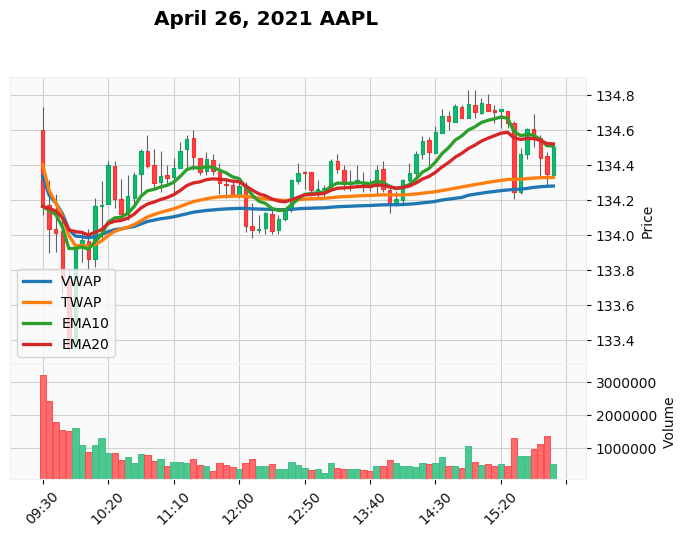

2021-04-26: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 37.268 AAPL short contracts at 134.1633 per contract
10:10:00: Close 37.268 AAPL short contracts at 134.1633 per contract
10:10:00: Buy 37.268 AAPL shares at 134.1633 per share
12:05:00: Sell 37.268 AAPL shares at 134.0535 per share
12:05:00: Open 37.268 AAPL short contracts at 134.0535 per contract
12:40:00: Close 37.268 AAPL short contracts at 134.3131 per contract
12:40:00: Buy 37.124 AAPL shares at 134.3131 per share
15:30:00: Sell 37.124 AAPL shares at 134.2482 per share
15:30:00: Open 37.124 AAPL short contracts at 134.2482 per contract
15:35:00: Close 37.124 AAPL short contracts at 134.4628 per contract
15:35:00: Buy 37.005 AAPL shares at 134.4628 per share
16:00:00: Sell 37.005 AAPL shares at 134.5027 per share
Cash: 4977.333567732611
Return: -0.45%
Transactions: 12
----------------------------------------------------------------------
2021-04-26: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy

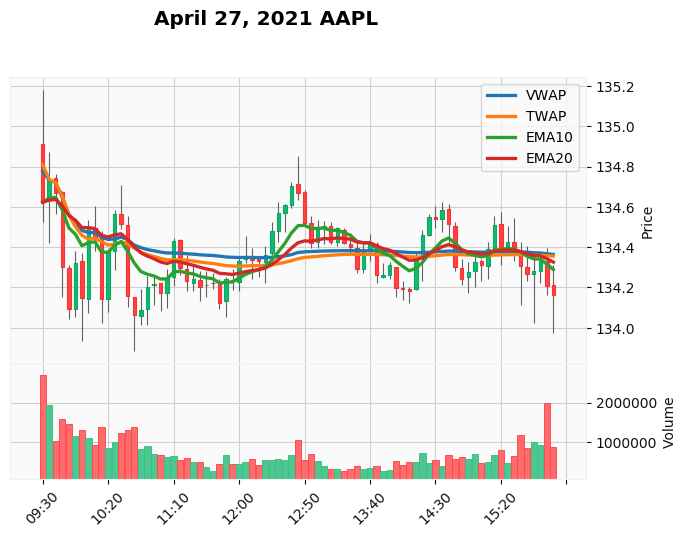

2021-04-27: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 37.141 AAPL short contracts at 134.6225 per contract
10:05:00: Close 37.141 AAPL short contracts at 134.4929 per contract
10:05:00: Buy 37.212 AAPL shares at 134.4929 per share
10:10:00: Sell 37.212 AAPL shares at 134.4427 per share
10:10:00: Open 37.212 AAPL short contracts at 134.4427 per contract
10:25:00: Close 37.212 AAPL short contracts at 134.5626 per contract
10:25:00: Buy 37.146 AAPL shares at 134.5626 per share
10:35:00: Sell 37.146 AAPL shares at 134.1554 per share
10:35:00: Open 37.146 AAPL short contracts at 134.1554 per contract
11:10:00: Close 37.146 AAPL short contracts at 134.4299 per contract
11:10:00: Buy 36.994 AAPL shares at 134.4299 per share
11:15:00: Sell 36.994 AAPL shares at 134.2981 per share
11:15:00: Open 36.994 AAPL short contracts at 134.2981 per contract
12:20:00: Close 36.994 AAPL short contracts at 134.363 per contract
12:20:00: Buy 36.959 AAPL shares at 134.363 per share
13:30:00

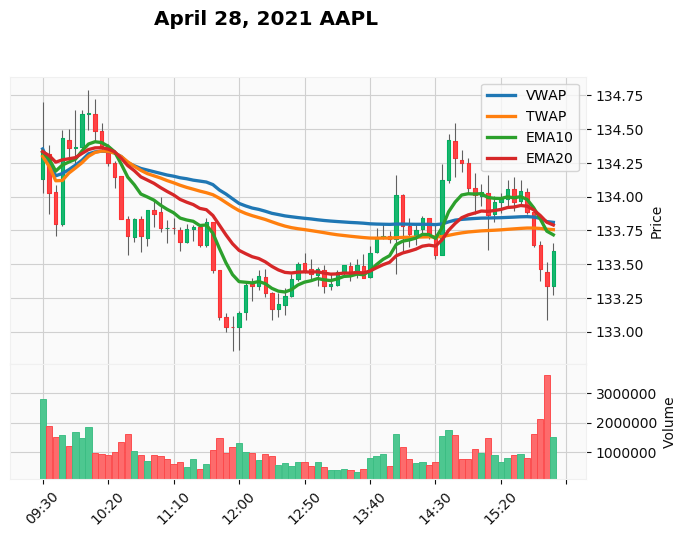

2021-04-28: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 37.221 AAPL short contracts at 134.333 per contract
09:45:00: Close 37.221 AAPL short contracts at 134.4329 per contract
09:45:00: Buy 37.166 AAPL shares at 134.4329 per share
10:20:00: Sell 37.166 AAPL shares at 134.2514 per share
10:20:00: Open 37.166 AAPL short contracts at 134.2514 per contract
14:00:00: Close 37.166 AAPL short contracts at 134.0136 per contract
14:00:00: Buy 37.298 AAPL shares at 134.0136 per share
14:05:00: Sell 37.298 AAPL shares at 133.784 per share
14:05:00: Open 37.298 AAPL short contracts at 133.784 per contract
14:20:00: Close 37.298 AAPL short contracts at 133.8439 per contract
14:20:00: Buy 37.264 AAPL shares at 133.8439 per share
14:25:00: Sell 37.264 AAPL shares at 133.7116 per share
14:25:00: Open 37.264 AAPL short contracts at 133.7116 per contract
14:35:00: Close 37.264 AAPL short contracts at 134.1234 per contract
14:35:00: Buy 37.035 AAPL shares at 134.1234 per share
15:45:00:

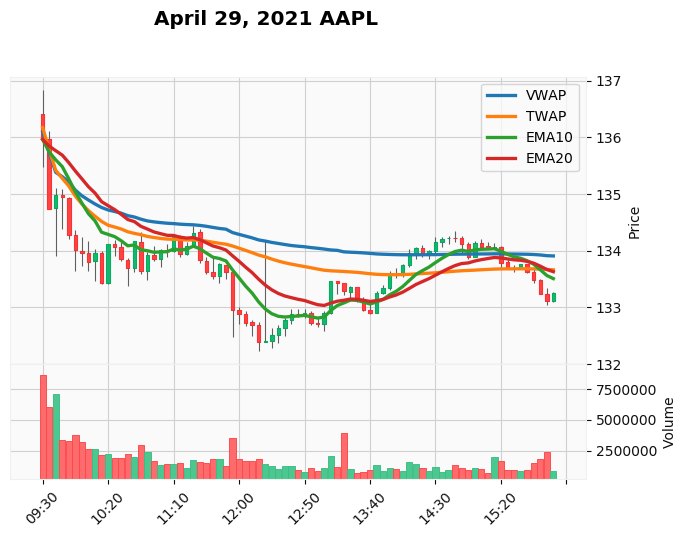

2021-04-29: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 36.775 AAPL short contracts at 135.9603 per contract
14:10:00: Close 36.775 AAPL short contracts at 133.9537 per contract
14:10:00: Buy 37.877 AAPL shares at 133.9537 per share
14:55:00: Sell 37.877 AAPL shares at 133.8849 per share
14:55:00: Open 37.877 AAPL short contracts at 133.8849 per contract
15:00:00: Close 37.877 AAPL short contracts at 134.1335 per contract
15:00:00: Buy 37.737 AAPL shares at 134.1335 per share
15:20:00: Sell 37.737 AAPL shares at 133.784 per share
15:20:00: Open 37.737 AAPL short contracts at 133.784 per contract
16:00:00: Close 37.737 AAPL short contracts at 133.2549 per contract
Cash: 5068.548903176059
Return: 1.37%
Transactions: 10
----------------------------------------------------------------------
2021-04-29: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 36.775 AAPL shares at 135.9603 per share
16:00:00: Sell 36.775 AAPL shares at 133.2549 per share
Cash: 4900.50772

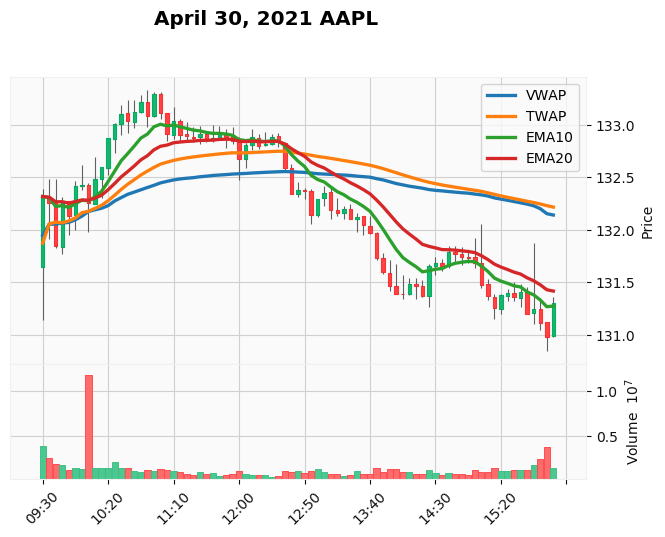

2021-04-30: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Buy 37.788 AAPL shares at 132.3164 per share
09:40:00: Sell 37.788 AAPL shares at 131.8471 per share
09:40:00: Open 37.788 AAPL short contracts at 131.8471 per contract
09:45:00: Close 37.788 AAPL short contracts at 132.2715 per contract
09:45:00: Buy 37.546 AAPL shares at 132.2715 per share
12:40:00: Sell 37.546 AAPL shares at 132.3414 per share
12:40:00: Open 37.546 AAPL short contracts at 132.3414 per contract
16:00:00: Close 37.546 AAPL short contracts at 131.2982 per contract
Cash: 5008.0208168186155
Return: 0.16%
Transactions: 8
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Open 37.788 AAPL short contracts at 132.3164 per contract
16:00:00: Close 37.788 AAPL short contracts at 131.2982 per contract
Cash: 5038.475956117306
Return: 0.77%
Transactions: 2
----------------------------------------------------------------------


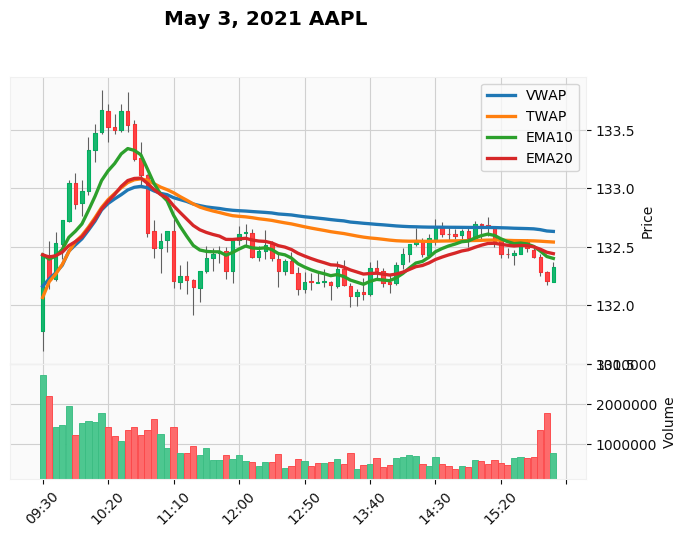

2021-05-03: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Buy 37.755 AAPL shares at 132.4312 per share
10:50:00: Sell 37.755 AAPL shares at 132.6209 per share
10:50:00: Open 37.755 AAPL short contracts at 132.6209 per contract
14:30:00: Close 37.755 AAPL short contracts at 132.6708 per contract
14:30:00: Buy 37.727 AAPL shares at 132.6708 per share
14:35:00: Sell 37.727 AAPL shares at 132.6061 per share
14:35:00: Open 37.727 AAPL short contracts at 132.6061 per contract
15:00:00: Close 37.727 AAPL short contracts at 132.6908 per contract
15:00:00: Buy 37.679 AAPL shares at 132.6908 per share
15:15:00: Sell 37.679 AAPL shares at 132.5461 per share
15:15:00: Open 37.679 AAPL short contracts at 132.5461 per contract
16:00:00: Close 37.679 AAPL short contracts at 132.3264 per contract
Cash: 5002.46770736841
Return: 0.05%
Transactions: 12
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Open 

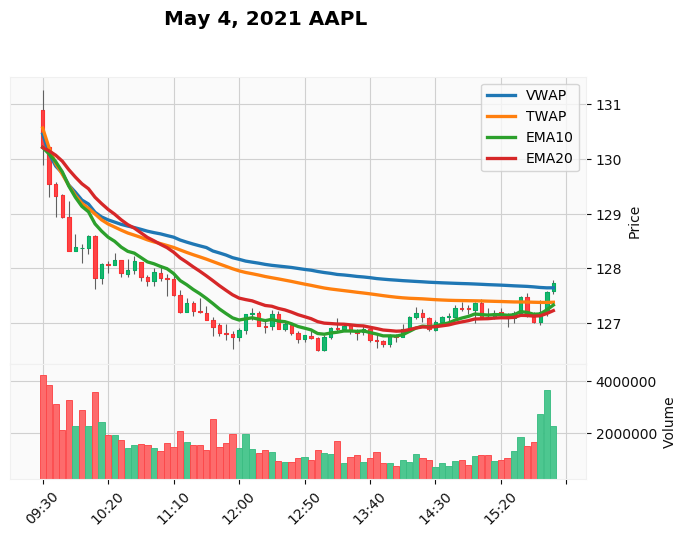

2021-05-04: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 38.400 AAPL short contracts at 130.21 per contract
16:00:00: Close 38.400 AAPL short contracts at 127.7242 per contract
16:00:00: Buy 39.894 AAPL shares at 127.7242 per share
16:00:00: Sell 39.894 AAPL shares at 127.7242 per share
Cash: 5095.453498195224
Return: 1.91%
Transactions: 4
----------------------------------------------------------------------
2021-05-04: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 38.400 AAPL shares at 130.21 per share
16:00:00: Sell 38.400 AAPL shares at 127.7242 per share
Cash: 4904.546501804776
Return: -1.91%
Transactions: 2
----------------------------------------------------------------------
2021-05-04: Starting EMA Cross strategy with $5000.0 USD
14:20:00: Buy 39.337 AAPL shares at 127.1052 per share
16:00:00: Sell 39.337 AAPL shares at 127.7242 per share
Cash: 5024.349908579665
Return: 0.49%
Transactions: 2
--------------------------------------------------------

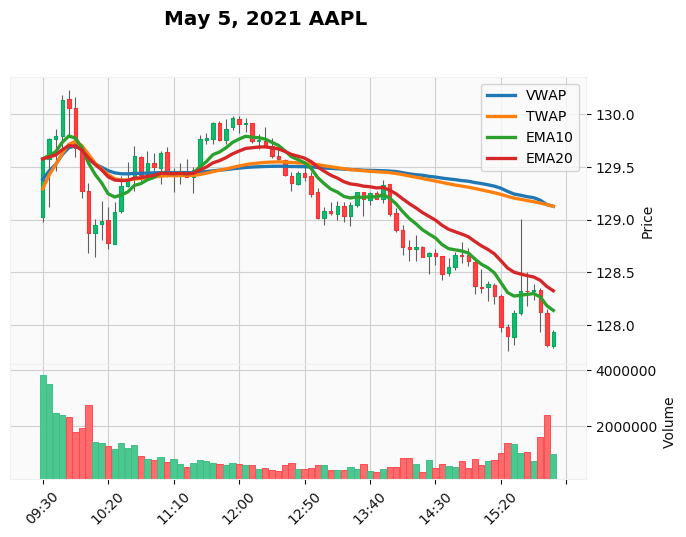

2021-05-05: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Buy 38.588 AAPL shares at 129.5741 per share
09:55:00: Sell 38.588 AAPL shares at 129.6809 per share
09:55:00: Open 38.588 AAPL short contracts at 129.6809 per contract
10:40:00: Close 38.588 AAPL short contracts at 129.601 per contract
10:40:00: Buy 38.636 AAPL shares at 129.601 per share
10:45:00: Sell 38.636 AAPL shares at 129.4213 per share
10:45:00: Open 38.636 AAPL short contracts at 129.4213 per contract
10:50:00: Close 38.636 AAPL short contracts at 129.5361 per contract
10:50:00: Buy 38.567 AAPL shares at 129.5361 per share
11:05:00: Sell 38.567 AAPL shares at 129.4212 per share
11:05:00: Open 38.567 AAPL short contracts at 129.4212 per contract
11:15:00: Close 38.567 AAPL short contracts at 129.4613 per contract
11:15:00: Buy 38.543 AAPL shares at 129.4613 per share
11:20:00: Sell 38.543 AAPL shares at 129.4014 per share
11:20:00: Open 38.543 AAPL short contracts at 129.4014 per contract
11:25:00: Close 38.54

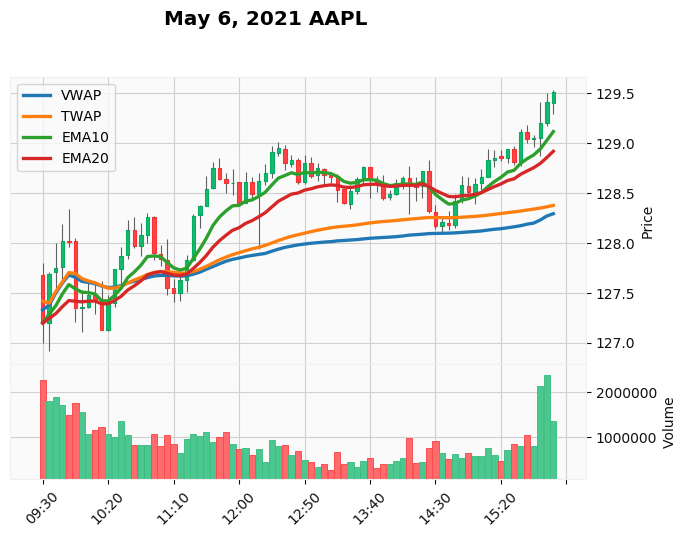

2021-05-06: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 39.310 AAPL short contracts at 127.1951 per contract
09:35:00: Close 39.310 AAPL short contracts at 127.6872 per contract
09:35:00: Buy 39.007 AAPL shares at 127.6872 per share
09:55:00: Sell 39.007 AAPL shares at 127.3448 per share
09:55:00: Open 39.007 AAPL short contracts at 127.3448 per contract
10:25:00: Close 39.007 AAPL short contracts at 127.734 per contract
10:25:00: Buy 38.769 AAPL shares at 127.734 per share
11:05:00: Sell 38.769 AAPL shares at 127.5445 per share
11:05:00: Open 38.769 AAPL short contracts at 127.5445 per contract
11:20:00: Close 38.769 AAPL short contracts at 127.8291 per contract
11:20:00: Buy 38.596 AAPL shares at 127.8291 per share
16:00:00: Sell 38.596 AAPL shares at 129.5112 per share
Cash: 4998.660962036424
Return: -0.03%
Transactions: 12
----------------------------------------------------------------------
2021-05-06: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 3

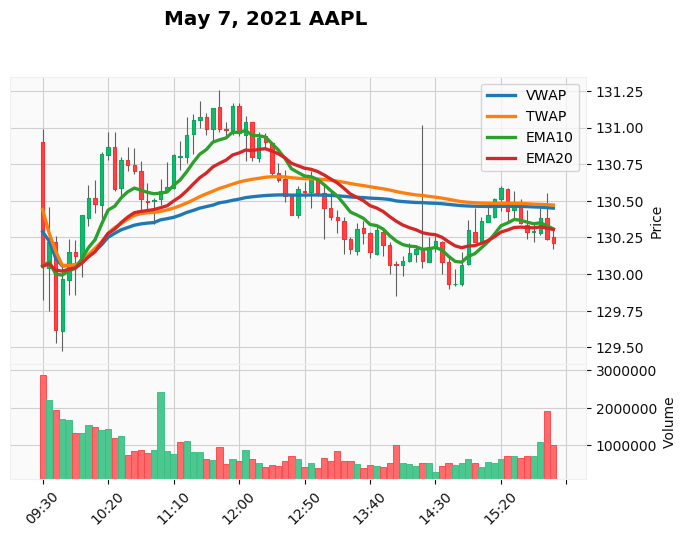

2021-05-07: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 38.446 AAPL short contracts at 130.0535 per contract
09:50:00: Close 38.446 AAPL short contracts at 130.1499 per contract
09:50:00: Buy 38.389 AAPL shares at 130.1499 per share
12:35:00: Sell 38.389 AAPL shares at 130.535 per share
12:35:00: Open 38.389 AAPL short contracts at 130.535 per contract
12:45:00: Close 38.389 AAPL short contracts at 130.58 per contract
12:45:00: Buy 38.362 AAPL shares at 130.58 per share
13:05:00: Sell 38.362 AAPL shares at 130.45 per share
13:05:00: Open 38.362 AAPL short contracts at 130.45 per contract
15:15:00: Close 38.362 AAPL short contracts at 130.51 per contract
15:15:00: Buy 38.327 AAPL shares at 130.51 per share
15:25:00: Sell 38.327 AAPL shares at 130.4311 per share
15:25:00: Open 38.327 AAPL short contracts at 130.4311 per contract
15:30:00: Close 38.327 AAPL short contracts at 130.48 per contract
15:30:00: Buy 38.298 AAPL shares at 130.48 per share
15:35:00: Sell 38.298 AA

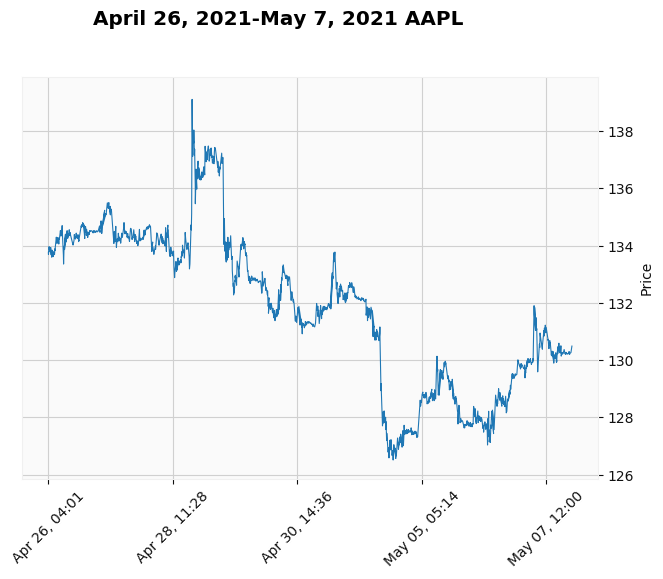

AAPL Returns
Strategy 1: 0.170%
Strategy 2: -0.056%
Strategy 3: -0.143%
Strategy 4: 0.170%
Market    : -0.555%
--------------------------------------------------


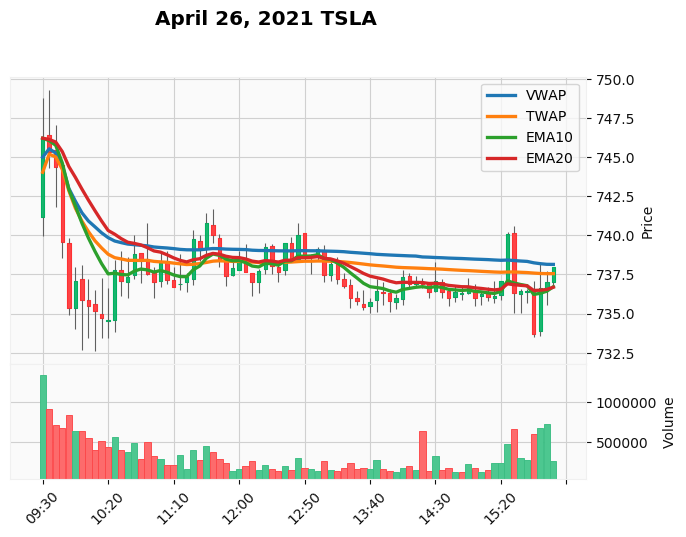

2021-04-26: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Buy 6.701 TSLA shares at 746.2 per share
09:35:00: Sell 6.701 TSLA shares at 745.3469 per share
09:35:00: Open 6.701 TSLA short contracts at 745.3469 per contract
11:25:00: Close 6.701 TSLA short contracts at 739.77 per contract
11:25:00: Buy 6.802 TSLA shares at 739.77 per share
11:45:00: Sell 6.802 TSLA shares at 738.34 per share
11:45:00: Open 6.802 TSLA short contracts at 738.34 per contract
12:20:00: Close 6.802 TSLA short contracts at 739.2477 per contract
12:20:00: Buy 6.785 TSLA shares at 739.2477 per share
12:25:00: Sell 6.785 TSLA shares at 738.065 per share
12:25:00: Open 6.785 TSLA short contracts at 738.065 per contract
12:35:00: Close 6.785 TSLA short contracts at 739.52 per contract
12:35:00: Buy 6.758 TSLA shares at 739.52 per share
12:40:00: Sell 6.758 TSLA shares at 738.4506 per share
12:40:00: Open 6.758 TSLA short contracts at 738.4506 per contract
12:45:00: Close 6.758 TSLA short contracts at 740.0

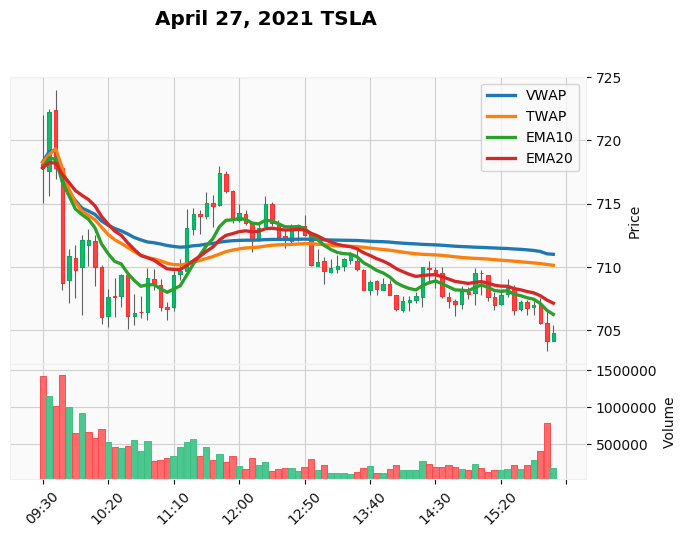

2021-04-27: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 6.966 TSLA short contracts at 717.82 per contract
09:35:00: Close 6.966 TSLA short contracts at 722.21 per contract
09:35:00: Buy 6.881 TSLA shares at 722.21 per share
09:40:00: Sell 6.881 TSLA shares at 717.8199 per share
09:40:00: Open 6.881 TSLA short contracts at 717.8199 per contract
11:20:00: Close 6.881 TSLA short contracts at 713.1 per contract
11:20:00: Buy 6.972 TSLA shares at 713.1 per share
12:35:00: Sell 6.972 TSLA shares at 712.0981 per share
12:35:00: Open 6.972 TSLA short contracts at 712.0981 per contract
12:40:00: Close 6.972 TSLA short contracts at 713.1047 per contract
12:40:00: Buy 6.952 TSLA shares at 713.1047 per share
12:55:00: Sell 6.952 TSLA shares at 710.18 per share
12:55:00: Open 6.952 TSLA short contracts at 710.18 per contract
16:00:00: Close 6.952 TSLA short contracts at 704.74 per contract
Cash: 4975.174480057433
Return: -0.50%
Transactions: 14
-------------------------------------

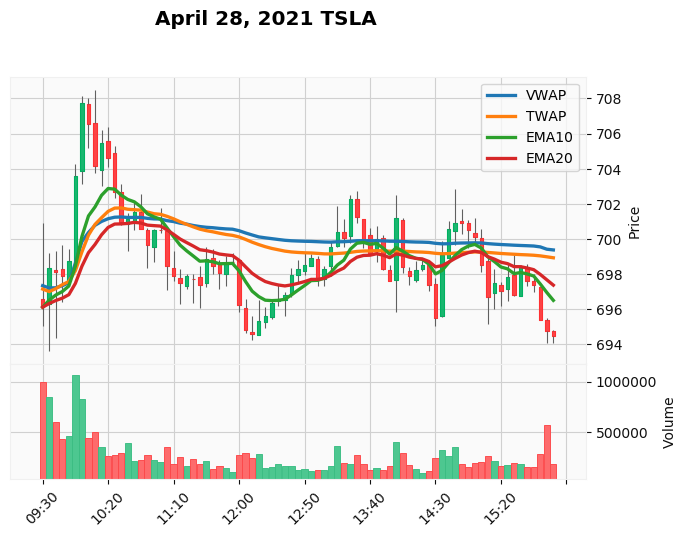

2021-04-28: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.183 TSLA short contracts at 696.0974 per contract
09:35:00: Close 7.183 TSLA short contracts at 698.31 per contract
09:35:00: Buy 7.137 TSLA shares at 698.31 per share
10:30:00: Sell 7.137 TSLA shares at 700.945 per share
10:30:00: Open 7.137 TSLA short contracts at 700.945 per contract
10:40:00: Close 7.137 TSLA short contracts at 701.4975 per contract
10:40:00: Buy 7.126 TSLA shares at 701.4975 per share
10:45:00: Sell 7.126 TSLA shares at 700.549 per share
10:45:00: Open 7.126 TSLA short contracts at 700.549 per contract
13:15:00: Close 7.126 TSLA short contracts at 700.4 per contract
13:15:00: Buy 7.129 TSLA shares at 700.4 per share
13:40:00: Sell 7.129 TSLA shares at 699.1961 per share
13:40:00: Open 7.129 TSLA short contracts at 699.1961 per contract
13:45:00: Close 7.129 TSLA short contracts at 699.96 per contract
13:45:00: Buy 7.114 TSLA shares at 699.96 per share
13:50:00: Sell 7.114 TSLA shares at 698

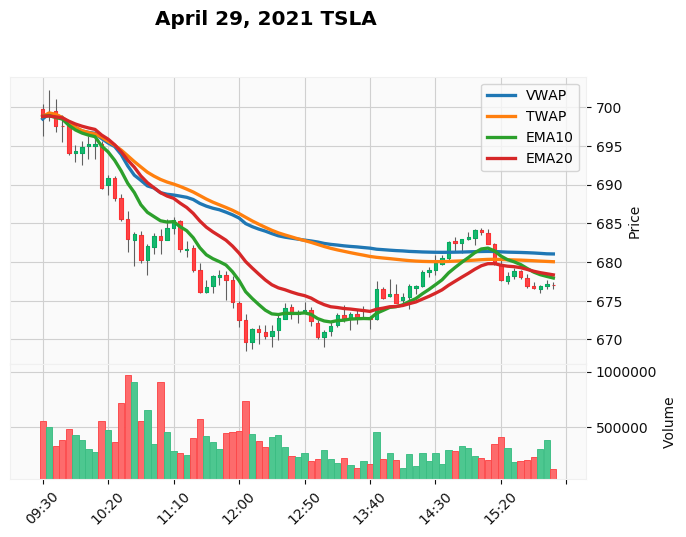

2021-04-29: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Buy 7.155 TSLA shares at 698.8046 per share
09:40:00: Sell 7.155 TSLA shares at 697.6 per share
09:40:00: Open 7.155 TSLA short contracts at 697.6 per contract
14:40:00: Close 7.155 TSLA short contracts at 682.64 per contract
14:40:00: Buy 7.469 TSLA shares at 682.64 per share
15:15:00: Sell 7.469 TSLA shares at 679.8456 per share
15:15:00: Open 7.469 TSLA short contracts at 679.8456 per contract
16:00:00: Close 7.469 TSLA short contracts at 677.0 per contract
Cash: 5098.803328481666
Return: 1.98%
Transactions: 8
----------------------------------------------------------------------
2021-04-29: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Open 7.155 TSLA short contracts at 698.8046 per contract
10:30:00: Close 7.155 TSLA short contracts at 685.5576 per contract
10:30:00: Buy 7.432 TSLA shares at 685.5576 per share
16:00:00: Sell 7.432 TSLA shares at 677.0 per share
Cash: 5031.186713188483
Return: 0.62%
Trans

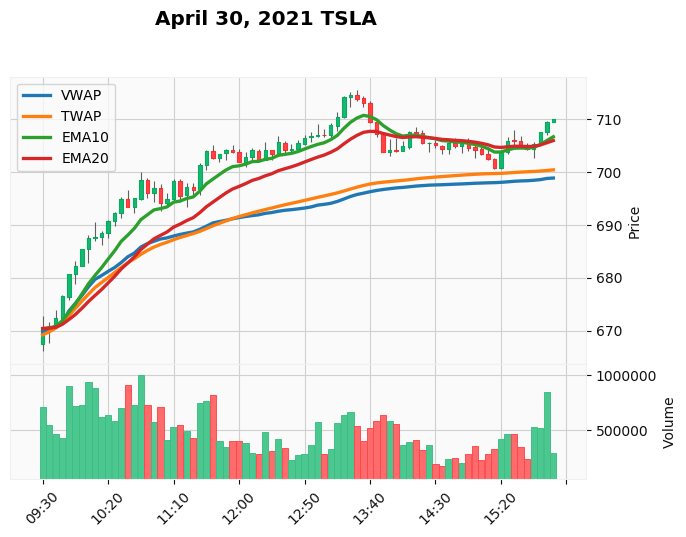

2021-04-30: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Buy 7.458 TSLA shares at 670.39 per share
16:00:00: Sell 7.458 TSLA shares at 709.84 per share
Cash: 5294.231715866884
Return: 5.88%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Open 7.458 TSLA short contracts at 670.39 per contract
16:00:00: Close 7.458 TSLA short contracts at 709.84 per contract
Cash: 4705.768284133116
Return: -5.88%
Transactions: 2
----------------------------------------------------------------------
2021-04-30: Starting EMA Cross strategy with $5000.0 USD
09:35:00: Buy 7.452 TSLA shares at 670.9178 per share
14:30:00: Sell 7.452 TSLA shares at 705.09 per share
15:50:00: Buy 7.428 TSLA shares at 707.43 per share
16:00:00: Sell 7.428 TSLA shares at 709.84 per share
Cash: 5272.568624113797
Return: 5.45%
Transactions: 4
----------------------------------------------------------------------
202

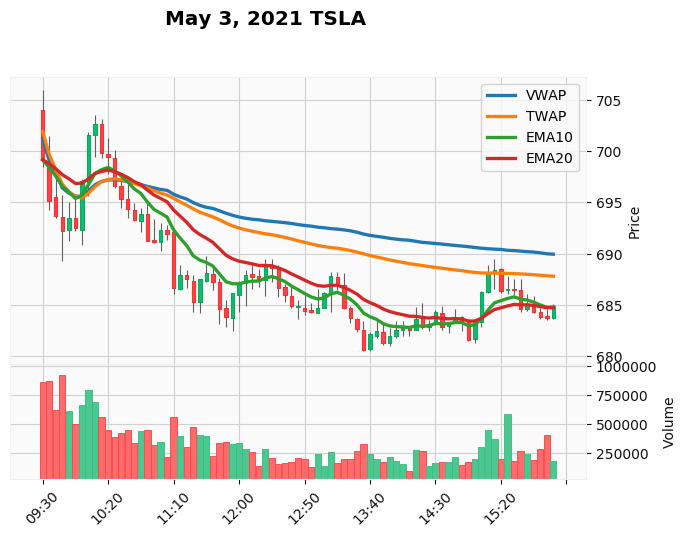

2021-05-03: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.151 TSLA short contracts at 699.16 per contract
10:00:00: Close 7.151 TSLA short contracts at 697.05 per contract
10:00:00: Buy 7.195 TSLA shares at 697.05 per share
10:25:00: Sell 7.195 TSLA shares at 696.58 per share
10:25:00: Open 7.195 TSLA short contracts at 696.58 per contract
16:00:00: Close 7.195 TSLA short contracts at 684.8748 per contract
Cash: 5095.923814696278
Return: 1.92%
Transactions: 6
----------------------------------------------------------------------
2021-05-03: Starting VWAP Mean reversion with $5000.0 USD
09:30:00: Buy 7.151 TSLA shares at 699.16 per share
16:00:00: Sell 7.151 TSLA shares at 684.8748 per share
Cash: 4897.840265461412
Return: -2.04%
Transactions: 2
----------------------------------------------------------------------
2021-05-03: Starting EMA Cross strategy with $5000.0 USD
10:10:00: Buy 7.116 TSLA shares at 702.64 per share
10:30:00: Sell 7.116 TSLA shares at 695.3616 per

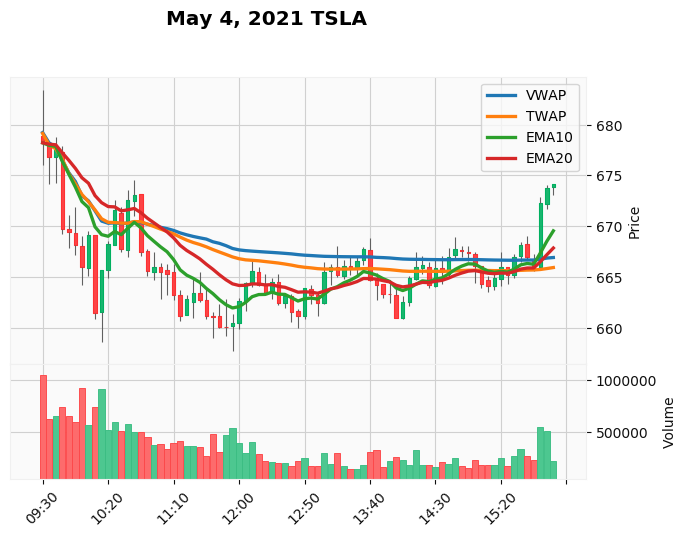

2021-05-04: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.372 TSLA short contracts at 678.21 per contract
10:25:00: Close 7.372 TSLA short contracts at 671.5937 per contract
10:25:00: Buy 7.518 TSLA shares at 671.5937 per share
10:30:00: Sell 7.518 TSLA shares at 667.75 per share
10:30:00: Open 7.518 TSLA short contracts at 667.75 per contract
10:35:00: Close 7.518 TSLA short contracts at 672.6 per contract
10:35:00: Buy 7.409 TSLA shares at 672.6 per share
10:45:00: Sell 7.409 TSLA shares at 667.4315 per share
10:45:00: Open 7.409 TSLA short contracts at 667.4315 per contract
13:35:00: Close 7.409 TSLA short contracts at 667.78 per contract
13:35:00: Buy 7.401 TSLA shares at 667.78 per share
13:40:00: Sell 7.401 TSLA shares at 664.74 per share
13:40:00: Open 7.401 TSLA short contracts at 664.74 per contract
14:40:00: Close 7.401 TSLA short contracts at 667.01 per contract
14:40:00: Buy 7.351 TSLA shares at 667.01 per share
15:00:00: Sell 7.351 TSLA shares at 666.1235 

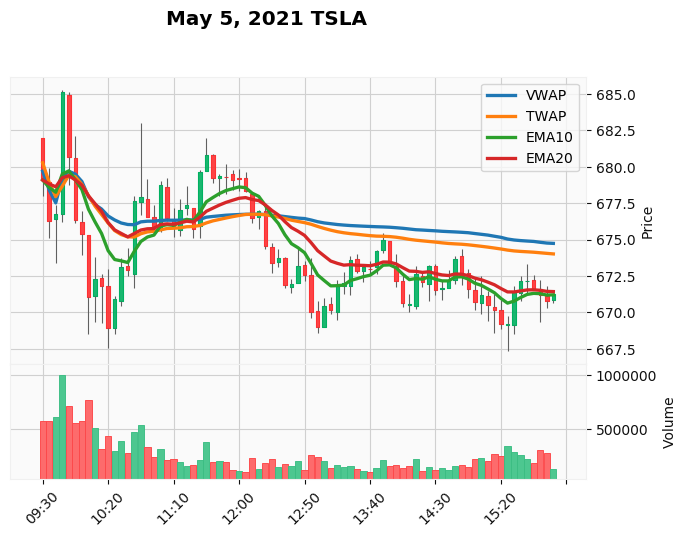

2021-05-05: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.363 TSLA short contracts at 679.0862 per contract
09:45:00: Close 7.363 TSLA short contracts at 685.135 per contract
09:45:00: Buy 7.233 TSLA shares at 685.135 per share
09:55:00: Sell 7.233 TSLA shares at 676.34 per share
09:55:00: Open 7.233 TSLA short contracts at 676.34 per contract
10:40:00: Close 7.233 TSLA short contracts at 677.6734 per contract
10:40:00: Buy 7.204 TSLA shares at 677.6734 per share
10:55:00: Sell 7.204 TSLA shares at 675.9008 per share
10:55:00: Open 7.204 TSLA short contracts at 675.9008 per contract
11:00:00: Close 7.204 TSLA short contracts at 678.715 per contract
11:00:00: Buy 7.145 TSLA shares at 678.715 per share
11:10:00: Sell 7.145 TSLA shares at 675.77 per share
11:10:00: Open 7.145 TSLA short contracts at 675.77 per contract
11:15:00: Close 7.145 TSLA short contracts at 677.03 per contract
11:15:00: Buy 7.118 TSLA shares at 677.03 per share
11:25:00: Sell 7.118 TSLA shares at 6

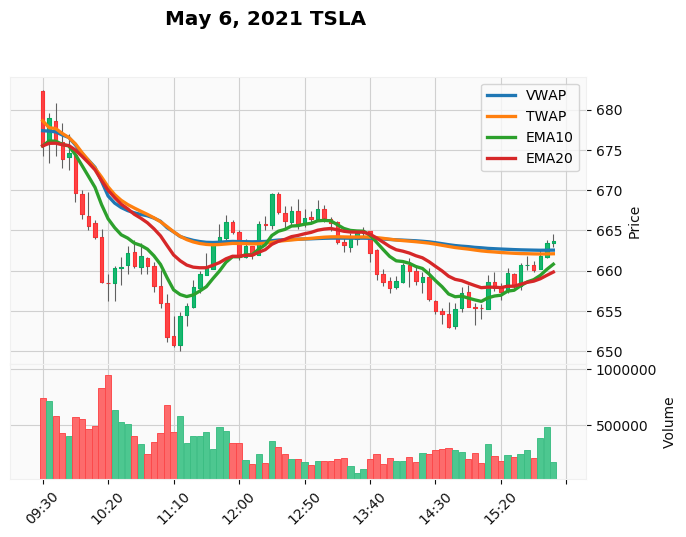

2021-05-06: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.402 TSLA short contracts at 675.48 per contract
09:35:00: Close 7.402 TSLA short contracts at 678.8899 per contract
09:35:00: Buy 7.328 TSLA shares at 678.8899 per share
09:40:00: Sell 7.328 TSLA shares at 675.9328 per share
09:40:00: Open 7.328 TSLA short contracts at 675.9328 per contract
11:40:00: Close 7.328 TSLA short contracts at 663.522 per contract
11:40:00: Buy 7.602 TSLA shares at 663.522 per share
12:00:00: Sell 7.602 TSLA shares at 661.7073 per share
12:00:00: Open 7.602 TSLA short contracts at 661.7073 per contract
12:15:00: Close 7.602 TSLA short contracts at 665.834 per contract
12:15:00: Buy 7.508 TSLA shares at 665.834 per share
13:15:00: Sell 7.508 TSLA shares at 663.54 per share
13:15:00: Open 7.508 TSLA short contracts at 663.54 per contract
13:30:00: Close 7.508 TSLA short contracts at 664.603 per contract
13:30:00: Buy 7.484 TSLA shares at 664.603 per share
13:40:00: Sell 7.484 TSLA shares 

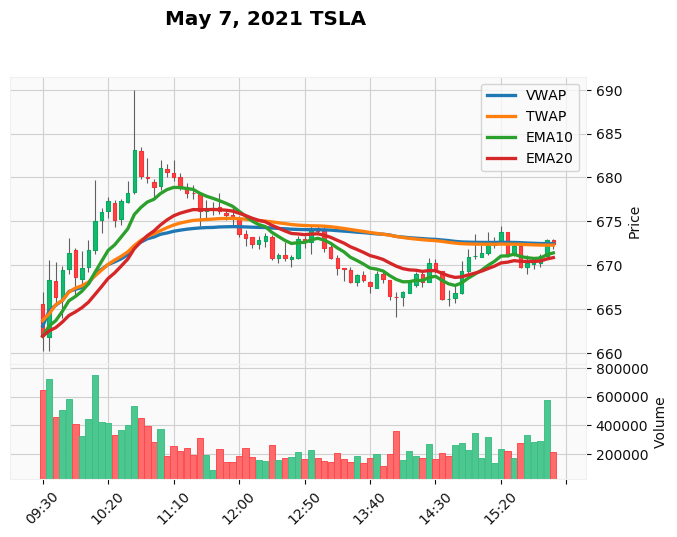

2021-05-07: Starting VWAP Cross strategy with $5000.0 USD
09:30:00: Open 7.554 TSLA short contracts at 661.9052 per contract
09:35:00: Close 7.554 TSLA short contracts at 668.3499 per contract
09:35:00: Buy 7.408 TSLA shares at 668.3499 per share
12:00:00: Sell 7.408 TSLA shares at 673.5617 per share
12:00:00: Open 7.408 TSLA short contracts at 673.5617 per contract
12:55:00: Close 7.408 TSLA short contracts at 674.152 per contract
12:55:00: Buy 7.395 TSLA shares at 674.152 per share
13:00:00: Sell 7.395 TSLA shares at 673.88 per share
13:00:00: Open 7.395 TSLA short contracts at 673.88 per contract
15:20:00: Close 7.395 TSLA short contracts at 673.76 per contract
15:20:00: Buy 7.398 TSLA shares at 673.76 per share
15:25:00: Sell 7.398 TSLA shares at 671.1658 per share
15:25:00: Open 7.398 TSLA short contracts at 671.1658 per contract
15:55:00: Close 7.398 TSLA short contracts at 672.9 per contract
15:55:00: Buy 7.360 TSLA shares at 672.9 per share
16:00:00: Sell 7.360 TSLA shares at 6

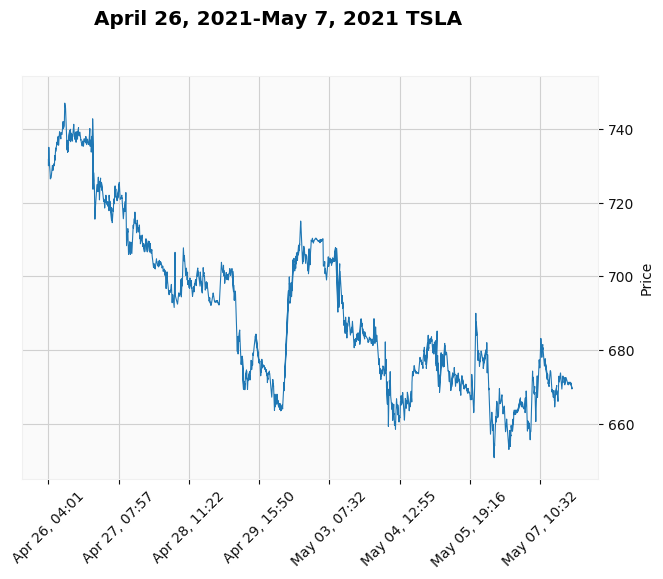

TSLA Returns
Strategy 1: -0.401%
Strategy 2: -0.248%
Strategy 3: -0.107%
Strategy 4: -0.401%
Market    : -0.619%
--------------------------------------------------
Portfolio Returns
Strategy 1: -0.115%
Strategy 2: -0.152%
Strategy 3: -0.125%
Strategy 4: -0.115%
Market    : -0.587%


In [12]:
portfolio = ['AAPL','TSLA'] 
cash = 100000 
show_transactions = True
show_graphs       = True 
main(portfolio,cash,show_transactions,show_graphs) 